# Time Series Prediction

In [92]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
#from keras.models import Sequential
#from keras.layers import Dense, Flatten, InputLayer, LSTM, Dropout, BatchNormalization, Conv1D, MaxPooling1D
#from keras.callbacks import EarlyStopping
import json
import random

In [93]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#from keras.models import Sequential
from statsmodels.tsa.statespace.sarimax import SARIMAX

## Read in Data

In [94]:
# Read in feature data
with open('../../../../data/feature_database.json') as json_database:
    database = json.load(json_database)
# Concat data
feature_data = None
for i in database:
    # Filter emission data
    if (database[i]['sector'] != 'target_values' and 
        database[i]['sector'] != 'greenhouse_emissions'):
        new_data = pd.read_json(database[i]['data'])
        if feature_data is None:
            feature_data = new_data
        else:
            feature_data = pd.concat([feature_data, new_data], axis=1, join="inner")
    else:
        print(f"Feature not used: {i}")
feature_data = feature_data.values
feature_data = feature_data.astype('float64')
print(f"Shape input features: {feature_data.shape}")
#feature_data.head()

Feature not used: E_Mio.tonnes_CO2
Feature not used: M_Mio.tonnes_CO2
Feature not used: ECO_Mio.tonnes_CO2
Feature not used: Total_CO2_Emission
Shape input features: (111, 40)


In [95]:
# Read in emission data
emission_data = pd.read_csv('../../../../data/greenhouse_emissions/oeko-institut_sektorale_abgrenzung_treibhausgasemissionen_daten_sektor_monthly.csv')
emission_data = emission_data['Total_CO2_Emission'].values
emission_data = emission_data.astype('float64')
# Take only the emissions on which we have indicators
emission_data = emission_data[len(emission_data)-feature_data.shape[0]:]
print(f"Shape output data: {emission_data.shape}")


Shape output data: (111,)


In [96]:
size = int(len(emission_data) *0.66 )
train, test = emission_data[0:size], emission_data[size:len(emission_data)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(6,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
#pyplot.plot(test)
#pyplot.plot(predictions, color='red')
#pyplot.show()

predicted=72.606196, expected=71.783835
predicted=73.965411, expected=73.778423
predicted=74.964923, expected=74.569796
predicted=71.755850, expected=72.960821
predicted=69.707550, expected=69.962304
predicted=67.477217, expected=67.992975
predicted=65.693325, expected=63.929514
predicted=61.928948, expected=61.396512
predicted=60.524604, expected=59.622069
predicted=61.037042, expected=62.671070
predicted=65.551618, expected=66.142827
predicted=68.775968, expected=68.274811
predicted=71.493799, expected=70.719476
predicted=72.832244, expected=72.600468
predicted=73.745218, expected=73.869133
predicted=71.226285, expected=72.314108
predicted=69.149432, expected=69.430539
predicted=66.939261, expected=67.506093
predicted=65.314135, expected=63.538393
predicted=61.562779, expected=61.042181
predicted=59.781306, expected=59.327879
predicted=60.704983, expected=62.302354
predicted=65.107512, expected=65.705654
predicted=68.276379, expected=67.791976
predicted=70.917021, expected=70.154215


In [97]:
train = emission_data
model = ARIMA(train, order=(5, 1, 1))  
fitted = model.fit(disp=-1)  

horizon = 48
# Forecast
fc, se, conf = fitted.forecast(horizon, alpha=0.01)  # 95% conf
forecastPlot = np.zeros((len(emission_data) + horizon))
forecastPlot[:] = np.nan
forecastPlot[len(emission_data):len(emission_data)+horizon] = fc[:]
# Make as pandas series
#fc_series = pd.Series(fc, index=test.index)


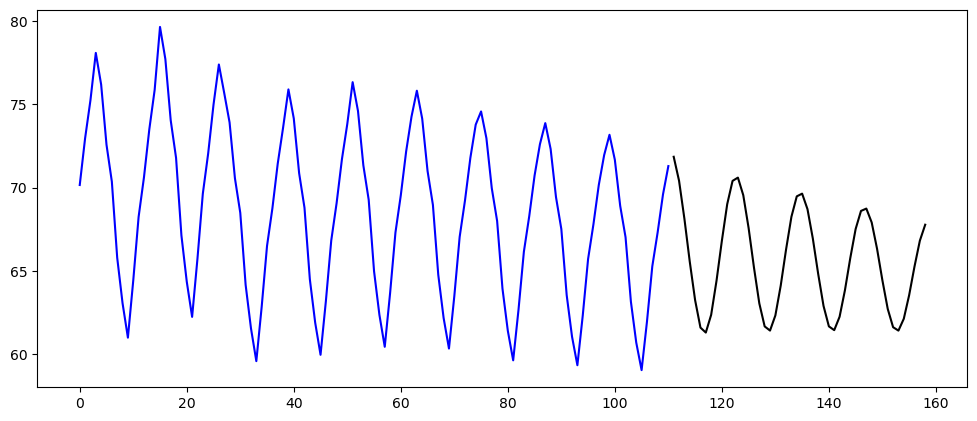

In [98]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training', color='blue')
#plt.plot(test, label='actual',color='orange')
plt.plot(forecastPlot, label='forecast',color='black')
plt.show()

0    70.152035
1    72.956128
2    75.243875
3    78.085788
4    76.184595
dtype: float64

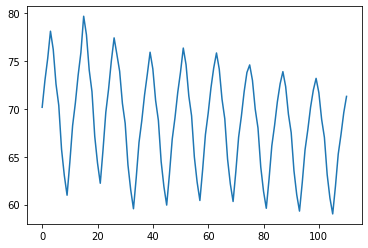

In [99]:
data= pd.Series(emission_data)
plt.plot(data)
#data = data.value[:100]
#test = data.value[100:]
data.head()

## Auto Arima Model

In [100]:
import pmdarima as pm

# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(data, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=False,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=481.807, BIC=492.645, Time=0.240 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=680.183, BIC=685.602, Time=0.013 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=536.802, BIC=544.931, Time=0.084 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=567.588, BIC=575.717, Time=0.052 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=1256.327, BIC=1259.036, Time=0.007 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=419.230, BIC=432.778, Time=0.299 seconds
Fit ARIMA(2,0,0)x(0,0,0,0) [intercept=True]; AIC=414.955, BIC=425.793, Time=0.075 seconds
Fit ARIMA(3,0,0)x(0,0,0,0) [intercept=True]; AIC=403.582, BIC=417.130, Time=0.073 seconds
Fit ARIMA(3,0,1)x(0,0,0,0) [intercept=True]; AIC=402.117, BIC=418.375, Time=0.363 seconds
Fit ARIMA(3,0,2)x(0,0,0,0) [intercept=True]; AIC=402.456, BIC=421.423, Time=0.536 seconds
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=426.8

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  111
Model:               SARIMAX(3, 0, 1)   Log Likelihood                -195.059
Date:                Wed, 05 Aug 2020   AIC                            402.117
Time:                        19:12:32   BIC                            418.375
Sample:                             0   HQIC                           408.712
                                - 111                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     22.0248      4.240      5.195      0.000      13.715      30.334
ar.L1          1.4428      0.259      5.566      0.000       0.935       1.951
ar.L2         -0.5102      0.436     -1.170      0.242      -1.365       0.344
ar.L3         -0.2540      0.237     -1.071      0.284      -0.719       0.211
ma.L1         -0.3080      0.243     -1.269      0.204      -0.784       0.168
sigma2         1.8485      0.304      6.078      0.000       1.252       2.445
===================================================================================
Ljung-Box (Q):                      365.37   Jarque-Bera (JB):                 7.53
Prob(Q):                              0.00   Prob(JB):                         0.02
Heteroskedasticity (H):               0.58   Skew:                             0.63
Prob(H) (two-sided):                  0.10   Kurtosis:                         2.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

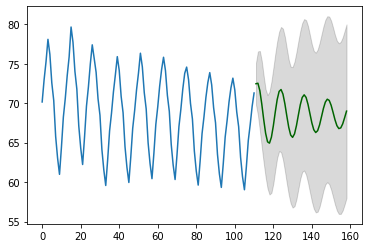

In [101]:
# Forecast
n_periods = 48
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
#index_of_fc = pd.date_range(data.index[-1], periods = n_periods, freq='MS')
index_of_fc = np.arange(len(data), len(data)+n_periods)

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(data)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)


## Auto Sarima Model

In [102]:
import pmdarima as pm

# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(data, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,1,1,12) [intercept=True]; AIC=171.520, BIC=184.445, Time=1.089 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=True]; AIC=215.916, BIC=221.086, Time=0.045 seconds
Fit ARIMA(1,1,0)x(1,1,0,12) [intercept=True]; AIC=191.305, BIC=201.645, Time=0.241 seconds
Fit ARIMA(0,1,1)x(0,1,1,12) [intercept=True]; AIC=169.536, BIC=179.876, Time=0.362 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=False]; AIC=213.941, BIC=216.526, Time=0.023 seconds
Fit ARIMA(0,1,1)x(0,1,0,12) [intercept=True]; AIC=217.829, BIC=225.583, Time=0.079 seconds
Fit ARIMA(0,1,1)x(1,1,1,12) [intercept=True]; AIC=170.303, BIC=183.228, Time=0.458 seconds
Fit ARIMA(0,1,1)x(0,1,2,12) [intercept=True]; AIC=157.295, BIC=170.220, Time=2.188 seconds
Near non-invertible roots for order (0, 1, 1)(0, 1, 2, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(0,1,1)x(1,1,0,12) [intercept=True]; AIC=191.299, BIC=201.63

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  111
Model:             SARIMAX(0, 1, 0)x(0, 1, [1, 2], 12)   Log Likelihood                 -73.861
Date:                                 Wed, 05 Aug 2020   AIC                            155.722
Time:                                         19:12:44   BIC                            166.062
Sample:                                              0   HQIC                           159.905
                                                 - 111                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0041      0.031     -0.131      0.895      -0.064       0.056
ma.S.L12      -1.5367      6.589     -0.233      0.816     -14.451      11.377
ma.S.L24       0.9936      8.530      0.116      0.907     -15.726      17.713
sigma2         0.1602      1.368      0.117      0.907      -2.520       2.841
===================================================================================
Ljung-Box (Q):                       35.10   Jarque-Bera (JB):              7686.71
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):               0.09   Skew:                            -5.53
Prob(H) (two-sided):                  0.00   Kurtosis:                        44.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

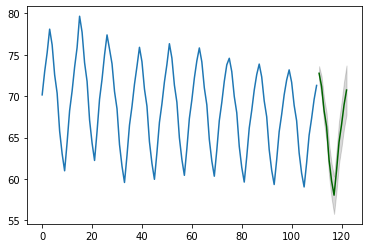

In [103]:
# Forecast
n_periods = 12
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
#index_of_fc = pd.date_range(data.index[-1], periods = n_periods, freq='MS')
index_of_fc = np.arange(len(data), len(data)+n_periods)

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(data)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

## Validate

In [104]:
#Check accuracy
data= pd.Series(emission_data)
split_train = np.arange(0, len(data)*0.8)
split_test = np.arange(len(data)*0.8, len(data))
train_data = pd.Series(data, index=split_train)
test_data = pd.Series(data, index=split_test)

In [105]:
import pmdarima as pm

# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(train_data, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,1,1,12) [intercept=True]; AIC=150.417, BIC=162.070, Time=1.207 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=True]; AIC=187.479, BIC=192.141, Time=0.048 seconds
Fit ARIMA(1,1,0)x(1,1,0,12) [intercept=True]; AIC=169.418, BIC=178.740, Time=0.227 seconds
Fit ARIMA(0,1,1)x(0,1,1,12) [intercept=True]; AIC=149.384, BIC=158.707, Time=0.945 seconds
Near non-invertible roots for order (0, 1, 1)(0, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=False]; AIC=185.504, BIC=187.835, Time=0.022 seconds
Fit ARIMA(1,1,1)x(0,1,0,12) [intercept=True]; AIC=187.425, BIC=196.748, Time=0.443 seconds
Near non-invertible roots for order (1, 1, 1)(0, 1, 0, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA(1,1,1)x(1,1,1,12) [intercept=True]; AIC=151.476, BIC=165.460, Time=1.345 seconds
N

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   89
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 12)   Log Likelihood                 -70.694
Date:                              Wed, 05 Aug 2020   AIC                            147.388
Time:                                      19:13:02   BIC                            154.380
Sample:                                           0   HQIC                           150.183
                                               - 89                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0177      0.059     -0.299      0.765      -0.134       0.098
ma.S.L12      -0.9978     33.486     -0.030      0.976     -66.629      64.634
sigma2         0.2754      9.216      0.030      0.976     -17.788      18.338
===================================================================================
Ljung-Box (Q):                        8.61   Jarque-Bera (JB):              7016.77
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.12   Skew:                            -6.17
Prob(H) (two-sided):                  0.00   Kurtosis:                        48.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

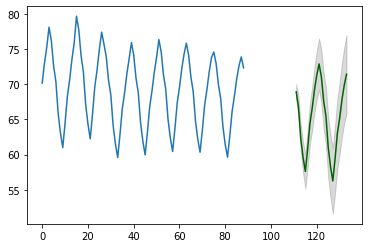

In [106]:
# Forecast
n_periods = 23
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
#index_of_fc = pd.date_range(data.index[-1], periods = n_periods, freq='MS')
index_of_fc = np.arange(len(data), len(data)+n_periods)

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(train_data)
plt.plot(test_data)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

In [107]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test_data)

ValueError: operands could not be broadcast together with shapes (48,) (23,) 

In [ ]:
# Forecast predictions
#forecastPlot = np.zeros((len(emission_data) + horizon))
#forecastPlot[:] = np.nan

#X = np.zeros((1, look_back))
#X[0] = emission_data[len(emission_data)-look_back:]
#predict = model.predict(X)
#forecastPlot[len(emission_data):len(emission_data)+horizon] = predict[:]

#print(f"Forecast: {predict}")

# Plot baseline, training, test and forecast
plt.plot(test, color='blue')
plt.plot(predictions, color='red')
#plt.plot(emission_data[:], color='green')
plt.plot(error, color='black')
#plt.plot(trainPredictPlot[:])
#plt.plot(testPredictPlot[:])
#plt.plot(forecastPlot[:])
plt.show()